In [27]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
sequence_length=4
batch_size=1
input_dim=512
d_model=512
x=torch.randn(batch_size,sequence_length,input_dim)

In [6]:
x.size()

torch.Size([1, 4, 512])

In [11]:
qkv_layer=nn.Linear(input_dim,3*d_model)

In [12]:
qkv=qkv_layer(x)

In [13]:
qkv.shape

torch.Size([1, 4, 1536])

<BarContainer object of 200 artists>

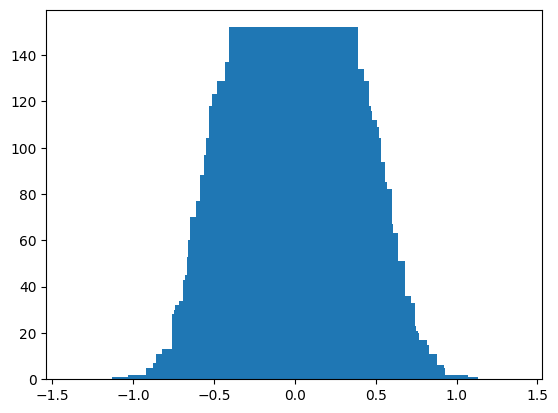

In [19]:
import matplotlib.pyplot as plt
y_val=torch.histc(qkv,bins=200,min=-3,max=3)
x_val=np.arange(-1,1,0.01)
plt.bar(x_val,y_val,align="center")

In [21]:
num_heads=8
head_dim=d_model//num_heads
qkv=qkv.reshape(batch_size,sequence_length,num_heads,3*head_dim)

In [22]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [24]:
qkv=qkv.permute(0,2,1,3)
qkv.shape

torch.Size([1, 8, 4, 192])

In [25]:
q,k,v=qkv.chunk(3,dim=-1)
q.shape,k.shape,v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [41]:
def scaled_dot_product(q,k,v,mask=None):
    d_k=q.size()[-1]
    scaled=torch.matmul(q,k.transpose(-1,-2))/math.sqrt(d_k)
    if mask is not None:
        scaled+=mask
    attention=F.softmax(scaled,dim=-1)
    out=torch.matmul(attention,v)
    return attention,out 


In [34]:
k.transpose(-1,-2).size()

torch.Size([1, 8, 64, 4])

In [31]:
scaled=torch.matmul(q,k.transpose(-1,-2))/math.sqrt(q.size()[-1])

In [32]:
scaled.size()

torch.Size([1, 8, 4, 4])

In [37]:
mask=torch.full(scaled.size(),float("-inf"))
mask=torch.triu(mask,diagonal=1)
mask.size()

torch.Size([1, 8, 4, 4])

In [39]:
(scaled+mask)[0][0]

tensor([[ 0.1741,    -inf,    -inf,    -inf],
        [-0.4089, -0.1842,    -inf,    -inf],
        [-0.2472,  0.6643, -0.8600,    -inf],
        [-0.1212, -0.1357,  0.4621,  0.4153]], grad_fn=<SelectBackward0>)

In [42]:
attention,values=scaled_dot_product(q,k,v,mask)

In [43]:
attention.size()

torch.Size([1, 8, 4, 4])

Complete Code

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
def scaled_dot_product(q,k,v,mask=None):
    d_k=q.size()[-1]
    scaled=torch.matmul(q,k.transpose(-1,-2))/math.sqrt(d_k)
    if mask is not None:
        scaled+=mask
    attention=F.softmax(scaled,dim=-1)
    out=torch.matmul(attention,v)
    return attention,out

class MultiheadAttention(nn.Module):
    def __init__(self,input_dim,d_model,num_heads):
        super().__init__()
        self.input_dim=input_dim
        self.d_model=d_model
        self.num_heads=num_heads
        self.head_dim=self.d_model//num_heads
        self.qkv_layer=nn.Linear(input_dim,3*d_model)
        self.linear_layer=nn.Linear(d_model,d_model)
    
    def forward(self,x,mask=None):
        batch_size,sequence_length,input_dim=x.size()
        qkv=self.qkv_layer(x)
        qkv=qkv.reshape(batch_size,sequence_length,self.num_heads,3*self.head_dim)
        qkv=qkv.permute(0,2,1,3)
        q,k,v=qkv.chunk(3,dim=-1)
        attention,values=scaled_dot_product(q,k,v,mask)
        values=values.reshape(batch_size,sequence_length,self.num_heads*self.head_dim)
        out=self.linear_layer(values)
        return out



In [50]:
input_dim=512
d_model=512
num_heads=8

batch_size=30
sequence_length=5
x=torch.randn((batch_size,sequence_length,input_dim))
model=MultiheadAttention(input_dim,d_model,num_heads)
out=model.forward(x)


In [51]:

import numpy as np
import math
import torch.nn as nn
import torch.nn.functional as F

def scaled_dot_product(q,k,v,mask=None):
    d_k=q.size()[-1]
    scaled=torch.matmul(q,k.transpose(-2,-1))/math.sqrt(k)
    if mask is not None:
        scaled+=mask
    attention=F.softmax(scaled)
    out=torch.matmul(attention,v)
    return out,attention

class MultiheadAttention(nn.Module):
    def __init__(self,input_dim,d_model,num_heads):
        super().__init__()
        self.input_dim=input_dim
        self.d_model=d_model
        self.num_heads=num_heads
        self.head_dim=self.input_dim//self.num_heads
        self.qkv_layer=nn.Linear(input_dim,3*self.d_model)
        self.linear_layer=nn.Linear(d_model,d_model)

torch.Size([30, 5, 512])
